## Setup

In [25]:
%matplotlib inline
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

In [2]:
BASE_PATH = "/content/drive/My Drive/obj tracking/"
DATASET_BASE_PATH = "/content/drive/My Drive/obj tracking/Bird species/"

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## Helper Functions

In [10]:
def augment_data(train_files, scale_factor=10):
  train_files = pd.concat([train_files]*scale_factor).reset_index(drop=True)
  return train_files

In [11]:
def imshow(img): 
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  x = np.transpose(npimg, (1, 2, 0))
  plt.imshow(x)
  plt.show()

In [44]:
def train_model(model, criterion, optimizer, train_loader, val_loader, 
                save_path, load_path=None,
                scheduler=None, n_epochs=1, valid_loss_min = np.Infinity):
  
  if load_path:
    model.load_state_dict(torch.load(load_path))

  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []

  total_step = len(train_loader)
  n_batch_print = (total_step - 1) / 3

  for epoch in range(1, n_epochs + 1): 
    since = time.time()

    running_loss = 0.0
    correct = 0
    total = 0

    model.train()

    for batch_idx, data in enumerate(train_loader): 
      # get the inputs; data is in list of [inputs, labels]
      inputs, targets = data

      # zero the parameter gradients 
      optimizer.zero_grad()

      # forward + backward + optimize 
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step() 

      # print stats
      running_loss += loss.item()

      # outputs gives C values, one for each class. we want to pick the highest
      # one which is the model's best prediction
      _, preds = torch.max(outputs, dim=1)
      correct += torch.sum(preds == targets).item()
      total += targets.size(0)

      if batch_idx % n_batch_print == 0: # print every n mini-batches
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
              .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        # running_loss = 0.0

    # step the lr_scheduler every epoch
    if scheduler:
      scheduler.step()

    # update performance stats for every epoch
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    
    # evaluate performance on validation data after each epoch
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
      model.eval()
      for inputs_t, targets_t in (val_loader):
        outputs_t = model(inputs_t)
        loss_t = criterion(outputs_t, targets_t)
        batch_loss += loss_t.item()
        _, preds_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(preds_t==targets_t).item()
        total_t += targets_t.size(0)
      val_acc.append(100 * correct_t / total_t)
      val_loss.append(batch_loss/len(val_loader))

      network_learned = batch_loss < valid_loss_min
      print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}')
      # Saving the best weight 
      if network_learned:
        print('Detected network improvement, saving current model\n')
        valid_loss_min = batch_loss
        torch.save(model.state_dict(), save_path)
      
    time_elapsed = time.time() - since
    print('Epoch completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # update lr_scheduler.step()


  print('Finished Training')
  return model, val_loss, val_acc, train_loss, train_acc, valid_loss_min

In [13]:
# helper functions for showing confusion matrix

def get_predictions(model, loader, all_data=False, iters=10):
  """Runs all data through the model to get predictions."""
  with torch.no_grad():
    model.eval()
    all_preds = []
    all_labels = []
    dataiter = iter(loader)
    for i in range(len(dataiter)):
      images, labels = dataiter.next()
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1) # type Tensor
      all_labels += labels.tolist()
      all_preds += preds.tolist()

    return all_labels, all_preds

def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
  """ This function prints and plots the confusion matrix with the true labels
      on the y-axis against the predicted labels on the x-axis.
      Normalization can be applied by setting `normalize=True`.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=80)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:np.newaxis]
    print('Normalized confusion matrix')
  else:
      print('Confusion matrix without normalization')

  color_thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])  ):
      plt.text(j, i, cm[i, j], horizontalalignment='center', 
               color='white' if cm[i, j] > color_thresh else 'black')
      
  # plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

## Data Preprocessing

In [15]:
# import data from google drive 
# note that the classes are assigned integers in alphabetical order
class_dict_orig = pd.read_csv(
    os.path.join(DATASET_BASE_PATH, "class_dict.csv"))['class'].to_dict()

metadata_orig = pd.read_csv(os.path.join(DATASET_BASE_PATH, 
                                                "Bird Species.csv"))
total_classes = len(class_dict_orig)

In [16]:
# select a subset of all our classes (faster to train)

num_classes = 20

# randomly chosen classes 
class_names = ['AMERICAN GOLDFINCH', 'AMERICAN REDSTART', 'BANDED BROADBILL', 
               'CASSOWARY', 'CHARA DE COLLAR', 'CINNAMON TEAL', 'COMMON LOON', 
               'CUBAN TROGON', 'EASTERN TOWEE', 'GLOSSY IBIS', 'GOLDEN EAGLE', 
               'HOUSE FINCH', 'IMPERIAL SHAQ', 'MALEO', 'PUFFIN', 
               'RED HONEY CREEPER', 'RED NAPED TROGON', 'TIT MOUSE', 
               'TURKEY VULTURE', 'VERMILION FLYCATHER']

class_dict = {i:class_names[i] for i in range(num_classes)}
print(class_names)
print(class_dict)

metadata_subset = metadata_orig[metadata_orig['labels'].isin(class_names)]
metadata_subset.sample(frac=1).head()

['AMERICAN GOLDFINCH', 'AMERICAN REDSTART', 'BANDED BROADBILL', 'CASSOWARY', 'CHARA DE COLLAR', 'CINNAMON TEAL', 'COMMON LOON', 'CUBAN TROGON', 'EASTERN TOWEE', 'GLOSSY IBIS', 'GOLDEN EAGLE', 'HOUSE FINCH', 'IMPERIAL SHAQ', 'MALEO', 'PUFFIN', 'RED HONEY CREEPER', 'RED NAPED TROGON', 'TIT MOUSE', 'TURKEY VULTURE', 'VERMILION FLYCATHER']
{0: 'AMERICAN GOLDFINCH', 1: 'AMERICAN REDSTART', 2: 'BANDED BROADBILL', 3: 'CASSOWARY', 4: 'CHARA DE COLLAR', 5: 'CINNAMON TEAL', 6: 'COMMON LOON', 7: 'CUBAN TROGON', 8: 'EASTERN TOWEE', 9: 'GLOSSY IBIS', 10: 'GOLDEN EAGLE', 11: 'HOUSE FINCH', 12: 'IMPERIAL SHAQ', 13: 'MALEO', 14: 'PUFFIN', 15: 'RED HONEY CREEPER', 16: 'RED NAPED TROGON', 17: 'TIT MOUSE', 18: 'TURKEY VULTURE', 19: 'VERMILION FLYCATHER'}


,filepaths,labels,data set
18602,train/GOLDEN EAGLE/100.jpg,GOLDEN EAGLE,train
1640,train/AMERICAN REDSTART/117.jpg,AMERICAN REDSTART,train
42590,train/VERMILION FLYCATHER/110.jpg,VERMILION FLYCATHER,train
23110,train/IMPERIAL SHAQ/121.jpg,IMPERIAL SHAQ,train
12115,train/COMMON LOON/072.jpg,COMMON LOON,train


In [ ]:
# encode the string labels using integers
lb = LabelEncoder()
metadata_subset['encoded labels'] = lb.fit_transform(metadata_subset['labels'])

# check a sample of the data to verify that the encoded labels are correct
# metadata_subset.sample(frac=1).head(20)

In [32]:
# sort the data into training, validation, and test data 
train_files = metadata_subset[metadata_subset['data set'] == 'train'].drop(columns=['data set'])
val_files = metadata_subset[metadata_subset['data set'] == 'valid'].drop(columns=['data set'])
test_files = metadata_subset[metadata_subset['data set'] == 'test'].drop(columns=['data set'])

# reset index to start at 0
train_files = train_files.reset_index(drop=True)
val_files = val_files.reset_index(drop=True)
test_files = test_files.reset_index(drop=True)

# check what the data looks like
val_files.sample(frac=1).head()

,filepaths,labels,encoded labels
56,valid/HOUSE FINCH/2.jpg,HOUSE FINCH,11
96,valid/VERMILION FLYCATHER/2.jpg,VERMILION FLYCATHER,19
27,valid/CINNAMON TEAL/3.jpg,CINNAMON TEAL,5
54,valid/GOLDEN EAGLE/5.jpg,GOLDEN EAGLE,10
90,valid/TURKEY VULTURE/1.jpg,TURKEY VULTURE,18


In [34]:
print('train_files shape before augmentation: ', train_files.shape)
train_files = augment_data(train_files, scale_factor=10)
print('train_files shape after augmentation: ', train_files.shape)

# check what the data looks like
train_files.sample(frac=1).head()

train_files shape before augmentation:  (2896, 3)
train_files shape after augmentation:  (28960, 3)


,filepaths,labels,encoded labels
9207,train/CASSOWARY/054.jpg,CASSOWARY,3
22518,train/RED HONEY CREEPER/092.jpg,RED HONEY CREEPER,15
24390,train/GLOSSY IBIS/003.jpg,GLOSSY IBIS,9
22587,train/RED NAPED TROGON/029.jpg,RED NAPED TROGON,16
11195,train/TIT MOUSE/063.jpg,TIT MOUSE,17


In [26]:
# define a transform function to transform image data into a tensor, then
# normalize btwn range [-1, 1]

transform_basic = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

transform_augment = transforms.Compose([
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ColorJitter(hue=.05, saturation=.05, 
                                     brightness=.05, contrast=.05),
  transforms.Pad(padding=90, padding_mode='reflect'),
  torchvision.transforms.RandomRotation(20),
  torchvision.transforms.CenterCrop(size=(224, 224)) # preserves orig size
  ])

In [27]:
# define a DataSet class to store our data 

class Bird_Dataset(Dataset): 
  def __init__(self, img_data, img_path, train=False, transform_basic=None, transform_augment=None):
    """ arguments:  img_data, DataFrame w/ file path, label, and encoded label
                    img_path, path to root folder of folders
                    transform, data transformation operation(s) to apply to raw
                      image data
    """
    self.img_data = img_data
    self.img_path = img_path
    self.is_train = train
    self.transform_basic = transform_basic
    self.transform_augment = transform_augment

  def __len__(self):
    return len(self.img_data)

  def __getitem__(self, index):
    """returns the data and labels in a tuple"""
    img_name = os.path.join(self.img_path, self.img_data.loc[index, 'filepaths'])
    # img_name = os.path.join(self.img_path, self.img_data['filepaths'][index])
    image = Image.open(img_name)
    # optional, can resize images here (or in the transformation pipeline). 
    # bird images are currently 224 x 224, no need to resize
    # image = image.resize((224, 224)) 
    label = torch.tensor(self.img_data.loc[index, 'encoded labels'])
    
    if self.is_train and self.transform_augment is not None:
      image = self.transform_augment(image)
    if self.transform_basic is not None: 
      image = self.transform_basic(image)
    return image, label

In [28]:
# create a Bird_Dataset object for each of our train, val, and test data

train_set = Bird_Dataset(train_files, DATASET_BASE_PATH, train=True, 
                         transform_basic=transform_basic, 
                         transform_augment=transform_augment)
val_set = Bird_Dataset(val_files, DATASET_BASE_PATH,
                       transform_basic=transform_basic)
test_set = Bird_Dataset(test_files, DATASET_BASE_PATH,
                        transform_basic=transform_basic)

In [29]:
# create DataLoaders, which can then iterate over our data 
batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

## Visualize Data

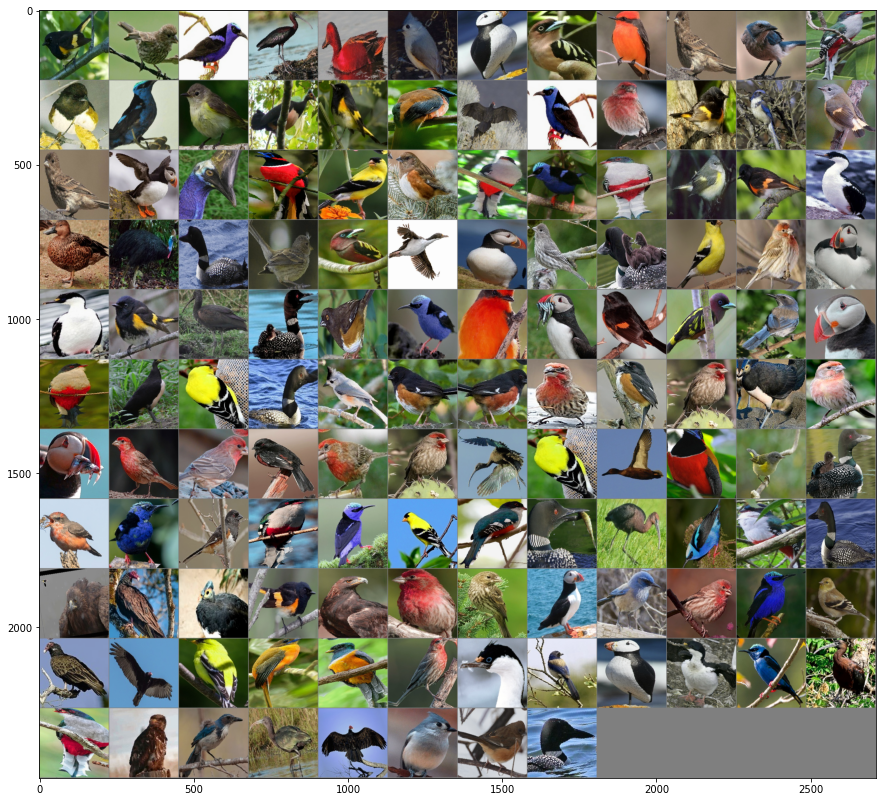

AMERICAN REDSTART; HOUSE FINCH; RED HONEY CREEPER; GLOSSY IBIS; CINNAMON TEAL; TIT MOUSE; PUFFIN; BANDED BROADBILL; VERMILION FLYCATHER; HOUSE FINCH; CHARA DE COLLAR; CUBAN TROGON; EASTERN TOWEE; RED HONEY CREEPER; AMERICAN REDSTART; MALEO; AMERICAN REDSTART; RED NAPED TROGON; TURKEY VULTURE; RED HONEY CREEPER; HOUSE FINCH; AMERICAN REDSTART; CHARA DE COLLAR; AMERICAN REDSTART; HOUSE FINCH; PUFFIN; CASSOWARY; RED NAPED TROGON; AMERICAN GOLDFINCH; EASTERN TOWEE; CUBAN TROGON; RED HONEY CREEPER; CUBAN TROGON; AMERICAN REDSTART; AMERICAN REDSTART; IMPERIAL SHAQ; CINNAMON TEAL; CASSOWARY; COMMON LOON; HOUSE FINCH; BANDED BROADBILL; IMPERIAL SHAQ; PUFFIN; HOUSE FINCH; COMMON LOON; AMERICAN GOLDFINCH; HOUSE FINCH; PUFFIN; IMPERIAL SHAQ; AMERICAN REDSTART; GLOSSY IBIS; COMMON LOON; EASTERN TOWEE; RED HONEY CREEPER; VERMILION FLYCATHER; PUFFIN; AMERICAN REDSTART; BANDED BROADBILL; CHARA DE COLLAR; PUFFIN; CUBAN TROGON; MALEO; AMERICAN GOLDFINCH; COMMON LOON; TIT MOUSE; EASTERN TOWEE; EASTERN T

In [35]:
# visualize image data: 
# get rand training imgs 

dataiter = iter(train_loader)
images, labels = dataiter.next() # gets [batch_size] number of images and labels 
fig = plt.figure(figsize=(15,15))
imshow(torchvision.utils.make_grid(images, nrow=12))
print('; '.join('%5s' % class_dict[labels[j].item()] for j in range(batch_size)))

## Define architecture of our neural network

In [36]:
class BirdNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    ### remove these ###
    # self.dropout = nn.Dropout2d(p=0.4)
    # self.batchnorm1 = nn.BatchNorm2d(16)
    # self.batchnorm2 = nn.BatchNorm2d(32)
    # self.batchnorm3 = nn.BatchNorm2d(64)
    ####################
    self.fc1 = nn.Linear(64 * 3 * 3, 256) # 64 * 3 * 3 = 576
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, num_classes) #num_classes = 10
    # TODO(QUESTION): is there a reason why the num inputs/outpus for these layers are
    # powers of 2? 

  def forward(self, x):
    # ###### remove these ########################
    # x = self.batchnorm1(F.relu(self.conv1(x)))
    # x = self.batchnorm2(F.relu(self.conv2(x)))
    # x = self.dropout(self.batchnorm2(self.pool(x)))
    # x = self.batchnorm3(F.relu(self.conv3(x)))
    # x = self.dropout(self.conv4(x))
    # # print('x shape after 4th conv', x.shape)
    # x = x.view(-1, 64 * 7 * 7) # Flatten layer
    # # print('x shape after flatten', x.shape)
    # x = self.dropout(self.fc1(x))
    # x = self.dropout(self.fc2(x))
    # # print('x shape after fc2', x.shape)
    # x = F.log_softmax(self.fc3(x), dim=1)
    # ##########################################

    ###################################
    # Daniel's suggestions from last yr
    x = self.pool(F.relu(self.conv1(x)))
    # print('x shape after 1 conv pool', x.shape)
    x = self.pool(F.relu(self.conv2(x)))
    # print('x shape after 2 conv pool', x.shape)
    x = self.pool(F.relu(self.conv3(x)))
    # print('x shape after 3 conv pool', x.shape)

    x = torch.flatten(x, 1) # Flatten all dimensions except the batch
    # print('x shape after flatten', x.shape)
    x = F.relu(self.fc1(x))
    # print('x shape after fc1', x.shape)
    x = F.relu(self.fc2(x))
    # print('x shape after fc2', x.shape)
    x = self.fc3(x)
    # print('x shape after fc3', x.shape)
    x = F.log_softmax(x, dim=1)

    return x

In [37]:
model = BirdNet(num_classes)

In [38]:
# define loss function 
criterion = nn.CrossEntropyLoss()

# define optimizer 
# optimizer = optim.SGD(midnet.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the neural net

In [39]:
birdnet_param_path = os.path.join(DATASET_BASE_PATH, 
                                                'birdnet_params.pt')

In [40]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
epochs = 0

As a sanity check, when we use the softmax classifier in our network, we expect the very first loss to be around -ln(0.05) = 2.9957. The network is effectively randomly choosing one of 20 classes and will have a 5% chance of being correct.

In [ ]:
model, val_loss_prog, val_acc_prog, train_loss_prog, train_acc_prog, valid_loss_min = train_model(
    model, criterion, optimizer, train_loader, val_loader, 
    save_path=birdnet_param_path, scheduler=None, n_epochs=10, 
    valid_loss_min=valid_loss_min)
  
val_loss += val_loss_prog
val_acc += val_acc_prog
train_loss += train_loss_prog
train_acc += train_acc_prog
epochs += 10

In [ ]:
# run for another 10 epochs
model, val_loss_prog, val_acc_prog, train_loss_prog, train_acc_prog, valid_loss_min = train_model(
    model, criterion, optimizer, train_loader, val_loader, 
    save_path=birdnet_param_path, load_path=birdnet_param_path, scheduler=None, n_epochs=10, 
    valid_loss_min=valid_loss_min)
  
val_loss += val_loss_prog
val_acc += val_acc_prog
train_loss += train_loss_prog
train_acc += train_acc_prog
epochs += 10

In [ ]:
# run for another 5 epochs (did not improve model)
model, val_loss_prog, val_acc_prog, train_loss_prog, train_acc_prog, valid_loss_min = train_model(
    model, criterion, optimizer, train_loader, val_loader, 
    save_path=birdnet_param_path, load_path=birdnet_param_path, scheduler=None, n_epochs=5, 
    valid_loss_min=valid_loss_min)
  
val_loss += val_loss_prog
val_acc += val_acc_prog
train_loss += train_loss_prog
train_acc += train_acc_prog
epochs += 5

## Examine model performance

Confusion matrix without normalization
val accuracy:  0.84


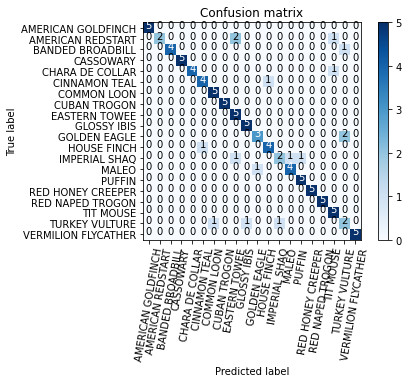

In [60]:
val_true, val_pred = get_predictions(model=model, loader=val_loader)

val_acc_score = accuracy_score(y_true=val_true, y_pred=val_pred)
cm = confusion_matrix(y_true=val_true, y_pred=val_pred)

cm_plot_labels = class_names

plot_confusion_matrix(cm=cm, classes=cm_plot_labels)
print('val accuracy: ', val_acc_score)
# accuracy = 86% at 20 epochs

Confusion matrix without normalization
test accuracy:  0.86


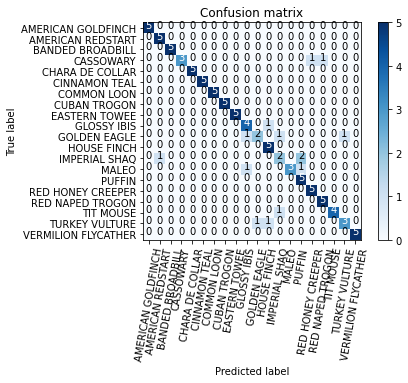

In [61]:
test_true, test_pred = get_predictions(model=model, loader=test_loader)

test_acc_score = accuracy_score(y_true=test_true, y_pred=test_pred)
test_cm = confusion_matrix(y_true=test_true, y_pred=test_pred)

cm_plot_labels = class_names

plot_confusion_matrix(cm=test_cm, classes=cm_plot_labels)
print('test accuracy: ', test_acc_score)
# accuracy = 83% at 20 epochs

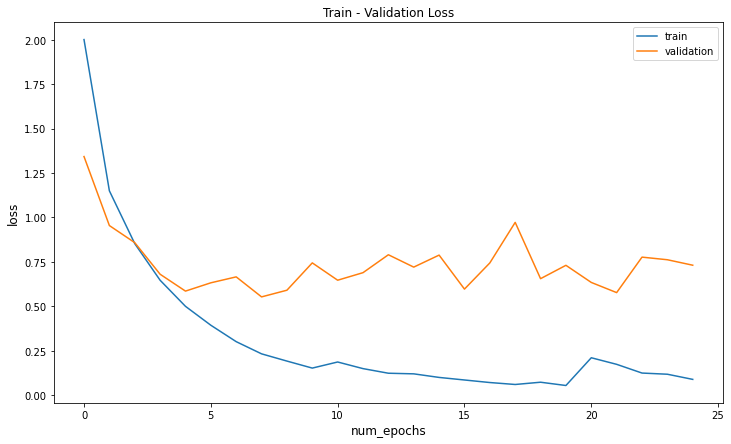

In [62]:
fig = plt.figure(figsize=(12,7))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.show()

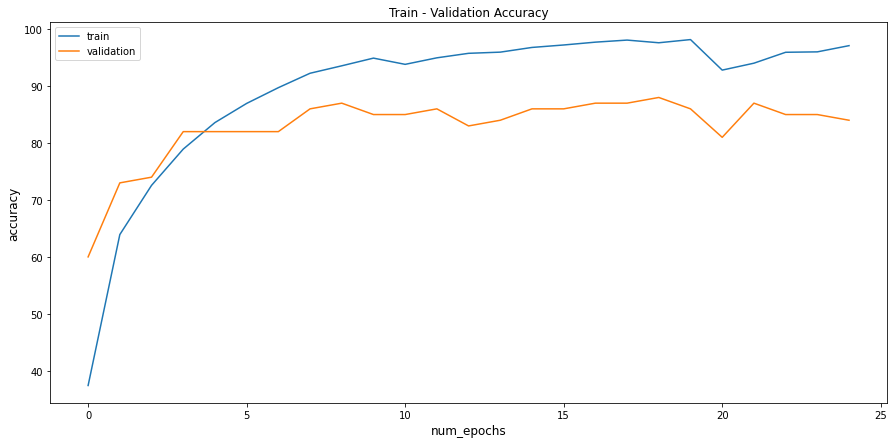

In [63]:
fig = plt.figure(figsize=(15,7))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.show()